In [2]:
# STEP 0: Install Libraries
# !pip install yfinance pandas numpy matplotlib scikit-learn tensorflow nltk

# --- Import Core Libraries ---
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import pytz
import requests
import matplotlib.pyplot as plt

# --- Import NLTK for Sentiment ---
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# --- Import Scikit-learn (sklearn) for Preprocessing & Metrics ---
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Import TensorFlow / Keras for LSTM Model ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Setup Matplotlib Style & NLTK Data ---
plt.style.use('seaborn-v0_8-darkgrid')
nltk.download('vader_lexicon', quiet=True)

print("All libraries imported successfully.")

All libraries imported successfully.


In [7]:
# --- Stock & Date Configuration ---
TICKER = input("Enter stock ticker(Example: 'TSLA'): ").strip().upper()
START_DATE = '2020-01-01'
END_DATE = '2024-01-01'

# --- Model & Forecast Configuration ---
TIME_STEP = 30      # How many past days of data to use for predicting the next day
FUTURE_DAYS = 30    # How many days into the future to forecast

# --- News API Configuration (EODHD) ---
NEWS_PROVIDER = "eodhd"
try:
    from google.colab import userdata
    NEWS_API_KEY = userdata.get('api_key') # Recommended: Use Colab Secrets
except Exception:
    NEWS_API_KEY = "demo" # Fallback if not in Colab or secret not set

if not NEWS_API_KEY:
    print("No EODHD API key found. Using demo key (limited).")
    NEWS_API_KEY = "demo"

print(f"Configuration loaded for ticker: {TICKER}")

Enter stock ticker(Example: 'TSLA'): googl
Configuration loaded for ticker: GOOGL


In [8]:
print(f"Fetching {TICKER} stock data from {START_DATE} to {END_DATE}...")

# Download historical data (daily prices)
data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)

# Flatten column names (if yfinance creates multi-level columns)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

# Basic cleaning: drop any rows with missing data
data.dropna(inplace=True)

# Show first few rows for verification
print(f"Dataset shape: {data.shape}")
print(data.head())

Fetching GOOGL stock data from 2020-01-01 to 2024-01-01...


[*********************100%***********************]  1 of 1 completed

Dataset shape: (1006, 5)
Price           Close       High        Low       Open    Volume
Date                                                            
2020-01-02  67.965233  67.965233  66.863336  66.958679  27278000
2020-01-03  67.609688  68.217003  66.904552  66.938323  23408000
2020-01-06  69.411766  69.437089  67.087298  67.118577  46768000
2020-01-07  69.277679  69.694308  69.101397  69.543349  34330000
2020-01-08  69.770782  70.108950  69.154534  69.263281  35314000


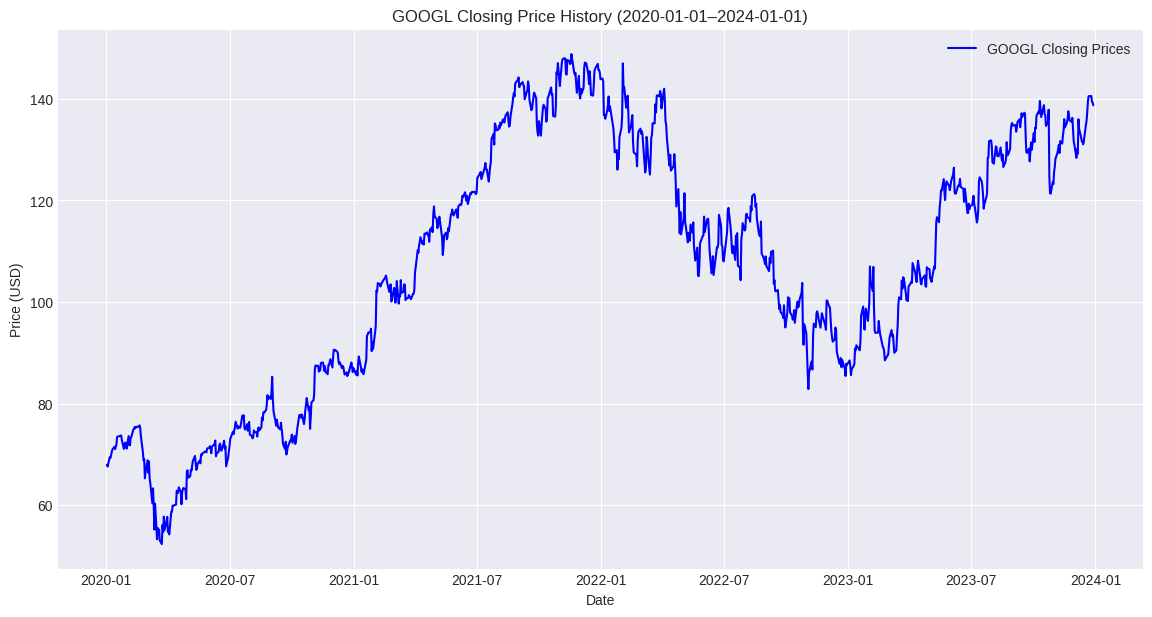

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label=f"{TICKER} Closing Prices", color='blue')
plt.title(f"{TICKER} Closing Price History ({START_DATE}–{END_DATE})")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [10]:
def get_company_news(ticker, start=None, end=None, limit=100, api_key=NEWS_API_KEY, provider=NEWS_PROVIDER):
    """
    Fetch up to `limit` real news headlines for sentiment analysis.
    Default provider = EODHD.
    Returns DataFrame: ['date', 'title']
    """
    headers = {"User-Agent": "market-forecast/1.0"}
    df = pd.DataFrame(columns=["date", "title"])

    # EODHD (DEFAULT)
    if provider.lower() == "eodhd":
        url = "https://eodhd.com/api/news"
        params = {
            "s": f"{ticker}.US",
            "limit": limit,
            "api_token": api_key,
            "fmt": "json"
        }
        # Add start and end date parameters for EODHD
        if start:
            params["from"] = start
        if end:
            params["to"] = end

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            news_data = r.json()
            if isinstance(news_data, list):
                df = pd.DataFrame([
                    {"date": item.get("date", "")[:10], "title": item.get("title", "")}
                    for item in news_data
                ])
        except Exception as e:
            print(f"EODHD news fetch failed: {e}")
            return df

    # Add other providers (Finnhub, NewsAPI) here if needed

    # Final cleanup
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
        df = df.dropna(subset=["date"]).reset_index(drop=True)
    return df

print("News fetching function 'get_company_news' defined.")

News fetching function 'get_company_news' defined.


In [11]:
print(f"Fetching news for {TICKER}...")
# Fetch news aligned with our stock data's date range
news_df = get_company_news(
    TICKER,
    start=data.index.min().strftime('%Y-%m-%d'),
    end=data.index.max().strftime('%Y-%m-%d'),
    limit=100 # Fetch up to 100 relevant headlines
)

if not news_df.empty:
    # Initialize VADER Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    # Calculate sentiment for each headline
    news_df['sentiment'] = news_df['title'].apply(
        lambda x: sia.polarity_scores(str(x))['compound'] if isinstance(x, str) else 0
    )

    # Aggregate sentiment by date (mean score for all headlines on a given day)
    daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()

    # Calculate one overall sentiment score for the entire period
    overall_sentiment_score = news_df['sentiment'].mean()

    print("\nSample of sentiment-scored headlines:")
    print(news_df[['date', 'sentiment', 'title']].head())
    print("\nDaily Sentiment Aggregated (Sample):")
    print(daily_sentiment.head())
    print(f"\nOverall sentiment score for the period: {overall_sentiment_score:.4f}")
else:
    print("No news found for the specified period. Proceeding without sentiment data.")
    # Create empty df to avoid errors later
    daily_sentiment = pd.DataFrame(columns=['date', 'sentiment'])
    overall_sentiment_score = 0

Fetching news for GOOGL...
EODHD news fetch failed: 403 Client Error: Forbidden for url: https://eodhd.com/api/news?s=GOOGL.US&limit=100&api_token=demo&fmt=json&from=2020-01-02&to=2023-12-29
No news found for the specified period. Proceeding without sentiment data.


In [12]:
print("Starting feature engineering...")

# 1. Create copy and reset index to get 'Date' as a column
data_multi = data.copy().reset_index()

# 2. Merge sentiment data
if not daily_sentiment.empty:
    # Convert 'date' column in daily_sentiment to datetime for consistent merging
    daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
    data_multi = data_multi.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
    if 'date' in data_multi.columns:
        data_multi.drop(columns=['date'], inplace=True)
else:
    # Add an empty sentiment column if no news was found
    data_multi['sentiment'] = 0

# Fill days with no news with a neutral sentiment (0)
data_multi['sentiment'] = data_multi['sentiment'].fillna(0)

# 3. Create technical indicators
data_multi['MA7'] = data_multi['Close'].rolling(window=7).mean()      # 7-day Moving Average
data_multi['MA30'] = data_multi['Close'].rolling(window=30).mean()    # 30-day Moving Average
data_multi['Daily_Return'] = data_multi['Close'].pct_change()         # Daily % change

# 4. Drop rows with NaN values (created by rolling windows/pct_change)
data_multi.dropna(inplace=True)

# 5. Define the feature set for the model
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment']
print(f"Features used for model: {features}")

# 6. Prepare the feature matrix
multi_data = data_multi[features].values

# 7. Scale all features between 0 and 1
# This is critical for LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_multi = scaler.fit_transform(multi_data)

print(f"Data prepared with {scaled_multi.shape[1]} features.")
print(data_multi.tail())

Starting feature engineering...
Features used for model: ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment']
Data prepared with 9 features.
Price       Date       Close        High         Low        Open    Volume  \
1001  2023-12-22  140.520813  141.017388  139.746157  139.805744  26532200   
1002  2023-12-26  140.550613  141.702656  140.222872  140.620126  16780300   
1003  2023-12-27  139.408493  141.106787  138.931785  140.620138  19628600   
1004  2023-12-28  139.269440  140.173210  138.792732  139.815675  16045700   
1005  2023-12-29  138.733139  139.398548  137.829369  138.673552  18733000   

Price  sentiment         MA7        MA30  Daily_Return  
1001           0  135.811866  133.888892      0.007620  
1002           0  137.171064  134.184520      0.000212  
1003           0  138.273457  134.458630     -0.008126  
1004           0  138.901978  134.677454     -0.000997  
1005           0  139.333287  134.845296     -0.003851  


In [13]:
X, y = [], []

for i in range(TIME_STEP, len(scaled_multi)):
    X.append(scaled_multi[i-TIME_STEP:i])  # Past 30 days of all features
    y.append(scaled_multi[i, 0])           # Target = next day's 'Close' price (which is the 0th feature)

X, y = np.array(X), np.array(y)

print(f"Original sequence shape (X): {X.shape}")
print(f"Original target shape (y): {y.shape}")

# Split into training & testing sets (80% train, 20% test)
# We don't shuffle time-series data!
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set (X, y): {X_train.shape}, {y_train.shape}")
print(f"Testing set (X, y): {X_test.shape}, {y_test.shape}")

Original sequence shape (X): (947, 30, 9)
Original target shape (y): (947,)
Training set (X, y): (757, 30, 9), (757,)
Testing set (X, y): (190, 30, 9), (190,)


In [14]:
# Callbacks for better training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5, # Increased from 3
    factor=0.5,
    verbose=1
)

# Build the LSTM model
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) # Output layer: 1 neuron for the predicted price
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

model.summary()

# Train the model
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    epochs=100, # Max epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 96)         │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,193 (344.50 KB)

 Trainable params: 88,193 (344.50 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0788 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0113 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0066 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0077 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0051 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0051 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0042
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0042 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0043 - val_loss: 0

Evaluating model performance...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step

        MODEL PERFORMANCE SUMMARY 

Mean Squared Error (MSE):      18.239847
Mean Absolute Error (MAE):     3.3940 USD
R² Score (Model Fit):          0.8349

Good model fit. Model captures major trends well.


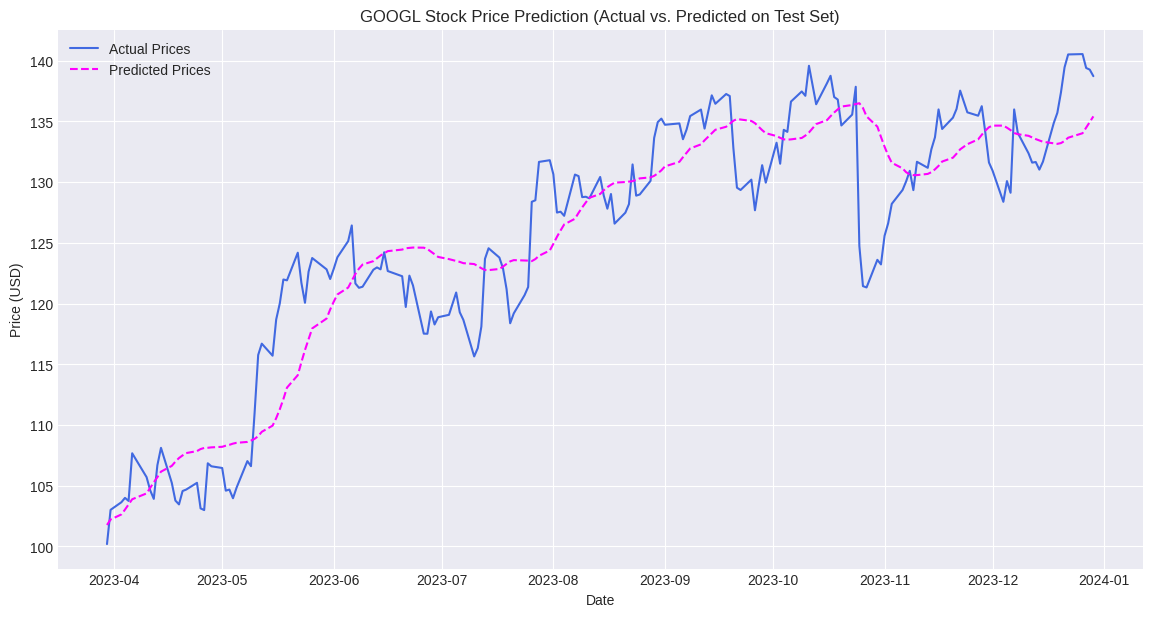

In [15]:
print("Evaluating model performance...")

# 1. Predict on the test set
predictions = model.predict(X_test)

# 2. Un-scale the predictions and actual values
# We must use the scaler's inverse_transform method

# Create dummy arrays to hold the predictions in the 'Close' column (index 0)
# This is the robust way to inverse_transform when you scaled multiple features
predictions_dummy = np.zeros((len(predictions), X_train.shape[2]))
predictions_dummy[:, 0] = predictions.flatten()
predictions_unscaled = scaler.inverse_transform(predictions_dummy)[:, 0]

y_test_dummy = np.zeros((len(y_test), X_train.shape[2]))
y_test_dummy[:, 0] = y_test.flatten()
y_test_actual_unscaled = scaler.inverse_transform(y_test_dummy)[:, 0]


# 3. Calculate performance metrics
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
mae = mean_absolute_error(y_test_actual_unscaled, predictions_unscaled)
r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)

# 4. Display performance summary
print("\n        MODEL PERFORMANCE SUMMARY \n")
print(f"Mean Squared Error (MSE):      {mse:.6f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f} USD")
print(f"R² Score (Model Fit):          {r2:.4f}")

if r2 > 0.9:
    print("\nExcellent model fit! Predictions closely follow actual prices.")
elif r2 > 0.75:
    print("\nGood model fit. Model captures major trends well.")
else:
    print("\nModel could be improved with more tuning or features.")

# 5. Plot actual vs. predicted prices
pred_dates = data_multi['Date'].iloc[-len(y_test_actual_unscaled):]

plt.figure(figsize=(14, 7))
plt.plot(pred_dates, y_test_actual_unscaled, label="Actual Prices", color='royalblue')
plt.plot(pred_dates, predictions_unscaled, label="Predicted Prices", color='magenta', linestyle='--')
plt.title(f"{TICKER} Stock Price Prediction (Actual vs. Predicted on Test Set)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [16]:
print(f"Generating future forecast for the next {FUTURE_DAYS} days...")

# Get the last 'time_step' days from the *full* dataset to start the forecast
last_sequence = scaled_multi[-TIME_STEP:]
future_input = last_sequence.reshape(1, TIME_STEP, X_train.shape[2])

future_predictions_scaled = []

for _ in range(FUTURE_DAYS):
    # Predict the next day's 'Close' price
    next_close_scaled = model.predict(future_input)[0][0]
    future_predictions_scaled.append(next_close_scaled)

    # Create the next input sequence:
    # 1. Start with the previous sequence and drop the first day
    next_sequence = future_input[:, 1:, :].copy()

    # 2. Create the new day's data
    new_day = future_input[:, -1, :].copy() # Get last day's features
    new_day[0][0] = next_close_scaled      # Update 'Close' with the predicted value

    # 3. Append the new day to the sequence
    next_sequence = np.append(next_sequence, new_day.reshape(1, 1, X_train.shape[2]), axis=1)
    future_input = next_sequence

# Un-scale the future predictions
future_predictions_dummy = np.zeros((len(future_predictions_scaled), X_train.shape[2]))
future_predictions_dummy[:, 0] = np.array(future_predictions_scaled).flatten()
future_predictions_unscaled = scaler.inverse_transform(future_predictions_dummy)[:, 0]

# Create future dates for the plot
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=FUTURE_DAYS, freq='B') # 'B' = business days

# Create the future forecast DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions_unscaled.flatten()
})

# Add the last known actual price to the start of the forecast for a continuous line
last_actual_point = pd.DataFrame({
    'Date': [data.index[-1]],
    'Predicted Price': [data['Close'].iloc[-1]]
})
future_df = pd.concat([last_actual_point, future_df], ignore_index=True)

print("\nPredicted Future Prices (Sample):\n")
print(future_df.head())

Generating future forecast for the next 30 days...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1


     Market Intelligence Summary: GOOGL
Latest Close Price: $138.73
Recent 5-Day Change: -1.27%

--- Sentiment Analysis ---
Overall Market Sentiment: Neutral (Score: 0.000)

--- 30-Day Forecast & Advice ---
Predicted change over next 30 days: -0.13%
Model Suggests: STABLE/NEUTRAL TREND – Model suggests HOLDING or monitoring.

Report generated on: 2025-11-19 02:05 PM ET


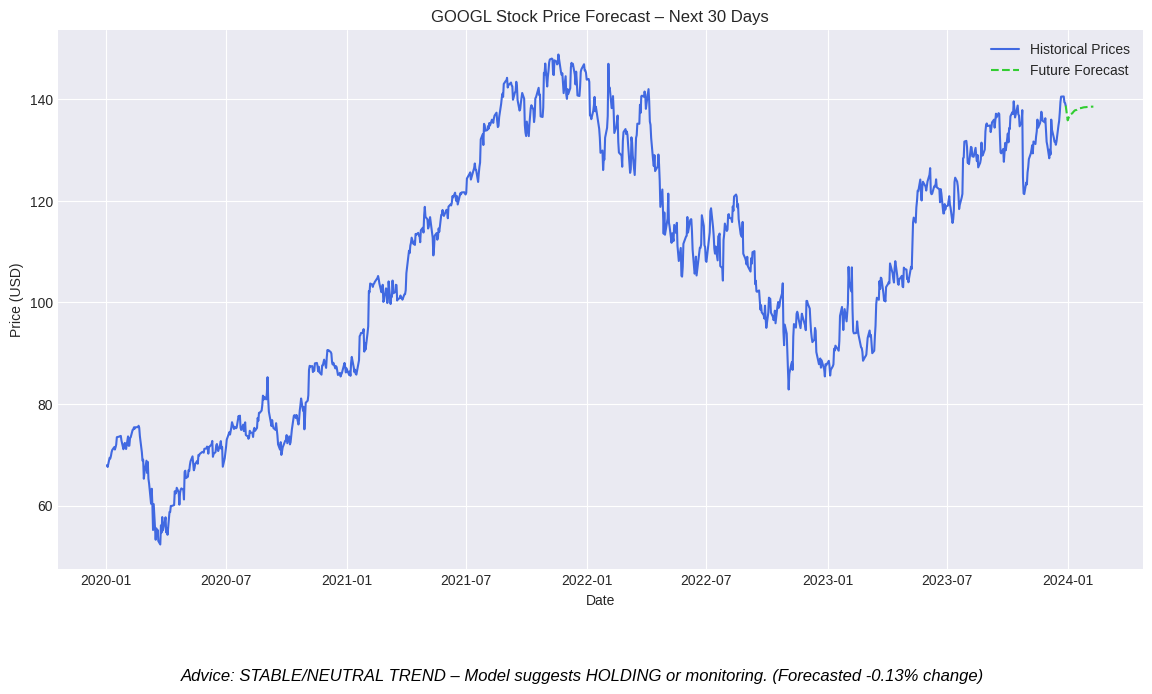

In [17]:
def generate_summary(ticker, price_data, sentiment_score):
    """Prints a formatted market intelligence summary."""
    latest_close = price_data['Close'].iloc[-1]
    week_change = ((latest_close - price_data['Close'].iloc[-5]) / price_data['Close'].iloc[-5]) * 100

    print("\n" + "="*40)
    print(f"     Market Intelligence Summary: {ticker}")
    print("="*40)
    print(f"Latest Close Price: ${latest_close:.2f}")
    print(f"Recent 5-Day Change: {week_change:.2f}%")

    print("\n--- Sentiment Analysis ---")
    if sentiment_score > 0.05:
        print(f"Overall Market Sentiment: Bullish (Score: {sentiment_score:.3f})")
    elif sentiment_score < -0.05:
        print(f"Overall Market Sentiment: Bearish (Score: {sentiment_score:.3f})")
    else:
        print(f"Overall Market Sentiment: Neutral (Score: {sentiment_score:.3f})")
    print("="*40)

# --- Generate the Summary ---
generate_summary(TICKER, data, overall_sentiment_score)

# --- Generate Investment Advice based on Forecast Trend ---
start_price = future_df['Predicted Price'].iloc[0] # Last actual price
end_price = future_df['Predicted Price'].iloc[-1] # Final predicted price
percent_change = ((end_price - start_price) / start_price) * 100

if percent_change > 5:
    advice = "STRONG UPTREND DETECTED !! – Model suggests a potential BUY opportunity."
elif percent_change < -5:
    advice = "DOWNTREND DETECTED – Model suggests caution or a potential SELL."
else:
    advice = "STABLE/NEUTRAL TREND – Model suggests HOLDING or monitoring."

print("\n--- 30-Day Forecast & Advice ---")
print(f"Predicted change over next {FUTURE_DAYS} days: {percent_change:.2f}%")
print(f"Model Suggests: {advice}")

# --- Generate Final Report Time ---
toronto_tz = pytz.timezone('America/Toronto')
local_time = datetime.datetime.now(toronto_tz)
print("\nReport generated on:", local_time.strftime("%Y-%m-%d %I:%M %p ET"))

# --- Plot Historical Data + Future Forecast ---
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label="Historical Prices", color='royalblue')
plt.plot(future_df['Date'], future_df['Predicted Price'], label="Future Forecast", color='limegreen', linestyle='--')
plt.title(f"{TICKER} Stock Price Forecast – Next {FUTURE_DAYS} Days")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.figtext(0.5, -0.05, f"Advice: {advice} (Forecasted {percent_change:.2f}% change)",
            wrap=True, ha='center', fontsize=12, color='black', style='italic')

# Save the final figure
plt.savefig(f"{TICKER}_Forecast_Results.png", dpi=300, bbox_inches='tight')

plt.show()